#### Importing the libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F

#### Root data directory path

In [3]:
data_dir = r"/content/drive/MyDrive/data"

#### Total number of classes

In [4]:
class_name = os.listdir(data_dir)
len(class_name)

2

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import transforms as T,datasets

#### Checking cuda availability

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:{}".format(device))

Device:cuda


#### Transforming the data

In [7]:
data_transform = T.Compose([
                             T.Resize(size=(224,224)), # Resizing the image to be 224 by 224
                             T.RandomRotation(degrees=(-20,+20)), #Randomly Rotate Images by +/- 20 degrees, Image augmentation for each epoch
                             T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
                             T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels

])

In [8]:
data = datasets.ImageFolder(data_dir, transform=data_transform)
total_count = len(data)

In [9]:
total_count

2640

In [10]:
data.classes

['Forged', 'Original']

#### Splitting the data

In [11]:
train_count = int(0.6 * total_count)
valid_count = int(0.3 * total_count)
test_count = total_count - train_count - valid_count
train_data, val_data, test_data = torch.utils.data.random_split(data, (train_count, valid_count, test_count))

In [12]:
len(train_data.indices)

1584

In [13]:
len(test_data.indices)

264

In [14]:
len(val_data.indices)

792

#### Defining some functions

In [15]:
def show_image(image,label,get_denormalize = True):

    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)

    else:
        plt.imshow(image)
        plt.title(label)


def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

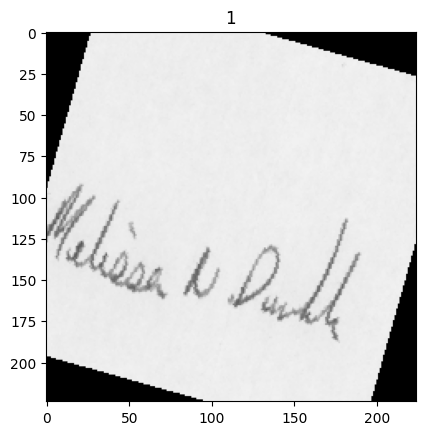

In [16]:
img, label = train_data[0]
show_image(img, label)

#### Data Loaders!

In [17]:
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))

validationloader = DataLoader(val_data, batch_size=32, shuffle=True)
print("No. of batches in validationloader:{}".format(len(validationloader)))
print("No. of Total examples:{}".format(len(validationloader.dataset)))

testloader = DataLoader(test_data ,batch_size=32, shuffle=False)
print("No. of batches in testloader:{}".format(len(testloader)))
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:50
No. of Total examples:1584
No. of batches in validationloader:25
No. of Total examples:792
No. of batches in testloader:9
No. of Total examples:264


#### Model

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import torchvision.transforms as transforms

In [19]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 163MB/s]


In [20]:
model.fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(model.fc.in_features, len(class_name))
)
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [21]:
def train(model, criterion, optimizer, train_dataloader, test_dataloader):

    total_train_loss = 0
    total_test_loss = 0

    model.train()
    with tqdm(train_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'training')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)
            output = model(images)

            loss = criterion(output, idxs)
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    train_acc = total_train_loss / len(train_data)
    test_acc = total_test_loss / len(val_data)
    print(f'Train loss: {train_acc:.4f} Test loss: {test_acc:.4f} ')


In [22]:
%%time
epochs=5
for i in range(epochs):
    print(f"Epoch {i+1}/{epochs}")
    train(model, criterion, optimizer, trainloader, validationloader)

Epoch 1/5


Train loss: 0.0078 Test loss: 0.0080 
Epoch 2/5


Train loss: 0.0003 Test loss: 0.0002 
Epoch 3/5


Train loss: 0.0005 Test loss: 0.0001 
Epoch 4/5


Train loss: 0.0004 Test loss: 0.0011 
Epoch 5/5


Train loss: 0.0003 Test loss: 0.0015 
CPU times: user 1min 35s, sys: 3.73 s, total: 1min 38s
Wall time: 10min 15s


#### Model saving

In [25]:
Path = r'/content/drive/MyDrive/model.pt'
torch.save(model, Path)

In [26]:
pwd

'/content'

#### Loading torch model

In [27]:
# Model class must be defined somewhere
model = torch.load(Path)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Model Evaluation

In [28]:
def evaluate(model, criterion, optimizer, test_dataloader):
    total_test_loss = 0

    model.eval()
    with tqdm(test_dataloader, unit='batch', leave=False) as pbar:
        pbar.set_description(f'testing')
        for images, idxs in pbar:
            images = images.to(device, non_blocking=True)
            idxs = idxs.to(device, non_blocking=True)

            output = model(images)
            loss = criterion(output, idxs)
            total_test_loss += loss.item()

    test_acc = total_test_loss / len(val_data)
    print(f'Test loss: {test_acc:.4f} ')

In [29]:
evaluate(model, criterion, optimizer, testloader)

Test loss: 0.0004 


#### Prediction

In [30]:
label_names = data.classes
label_names

['Forged', 'Original']

In [31]:
from PIL import Image

# Load the image and preprocess it
image = Image.open(r'/content/drive/MyDrive/data/Original/original_10_1.png')
preprocess = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.Grayscale(3),
    transforms.ToTensor()
])

image = preprocess(image)
image  = image[:3]

# Convert the image to a PyTorch tensor and send it to the device
image = image.unsqueeze(0).to(device)

# Make the prediction
with torch.no_grad():
    logits = model(image)
    probs = torch.softmax(logits, dim=1)
    pred_label = torch.argmax(probs, dim=1)

# Print the prediction
print(f'Predicted label: {pred_label.item()}')

# Map the predicted label to the corresponding class name
predicted_class_name = label_names[pred_label.item()]

# Print the predicted class name
print(f'Predicted class name: {predicted_class_name}')

Predicted label: 1
Predicted class name: Original
